# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
cust_resp = pd.merge(df_transactions, df_offers)
cust_offers = pd.pivot_table(cust_resp,index=['customer_name'],columns=['offer_id'], values='n') 
print(type(cust_offers))
cust_offers = cust_offers.fillna(0).reset_index()
print(cust_offers.head())

<class 'pandas.core.frame.DataFrame'>
offer_id customer_name    1    2    3    4    5    6    7    8    9  ...   23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

offer_id   24   25   26   27   28   29   30   31   32  
0         0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
1         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2         1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 33 columns]


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller SS indicate that clusters are tighter. Points within a cluster are closer togheter as the SS measure goes down.

In [5]:
# your turn
from sklearn.cluster import KMeans
cust_offers.shape

(100, 33)

In [6]:
# Create a numpy matrix with only columns representing purchases by offer
x_cols = cust_offers.iloc[:,1:].values

Text(0.5, 0, 'Number of Clusters')

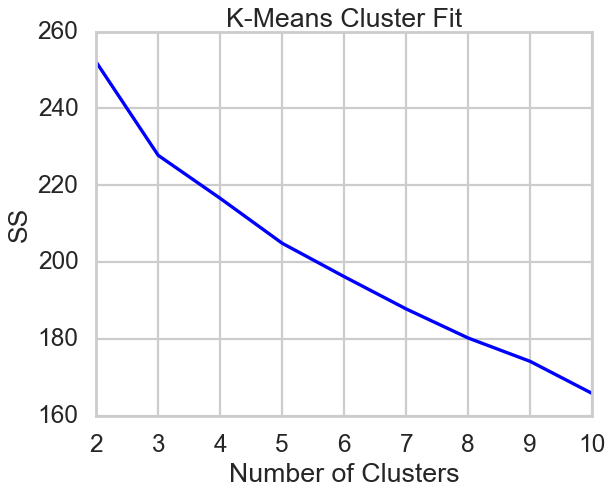

In [7]:
# Create clusters with KMeans for cluster size 2 through 10 and store sum of square of distance from each point to cluster centroid
ss = []
kk = []
for k in range(2,11):
    kmod = KMeans(n_clusters = k, random_state=20,init='k-means++')
    kmod.fit_predict(x_cols)
    ss.append(kmod.inertia_)
    kk.append(k)
    
plt.plot(kk,ss)
plt.title("K-Means Cluster Fit")
plt.ylabel("SS")
plt.xlabel("Number of Clusters")
    

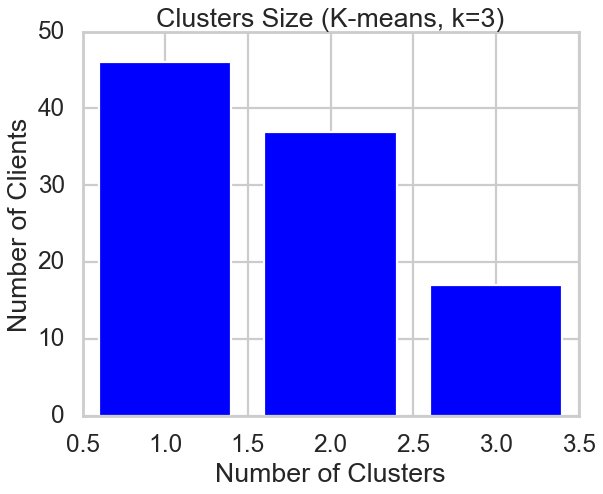

In [8]:
# Print the count of observations under each cluster
kmod = KMeans(n_clusters = 3)
cluster = pd.Series(kmod.fit_predict(x_cols))
cluster_points=cluster.value_counts()
_ = plt.bar(cluster_points.index+1,cluster_points)
_ = plt.xlabel("Number of Clusters")
_ = plt.ylabel("Number of Clients")
_ = plt.title("Clusters Size (K-means, k=3)")
plt.show()


The plot of the sum of squares (SS) when varying the number of clusters (K) shows how SS goes down as K increases with an almost linear relationship. There is only one clear breakning point (elbo) in the tradeoff betwen number of clusters and the improve in the fit, k=3. The change in the tradeoff after k=3 is small, but it seems it's a breaking point. An alternative is to pick a point in the linear curve showing a significant lower SS, but still a small number of clusters.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.08545917570828951


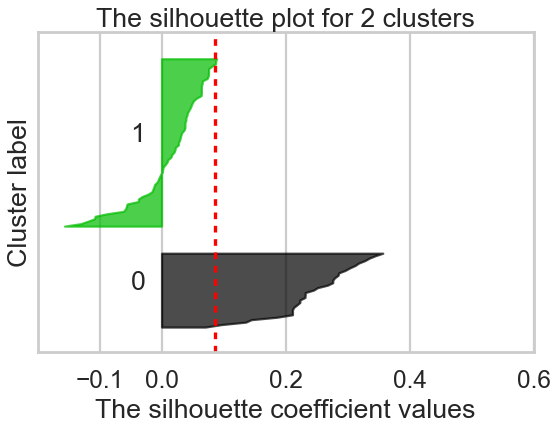

For n_clusters = 3 The average silhouette_score is : 0.12133064283950247


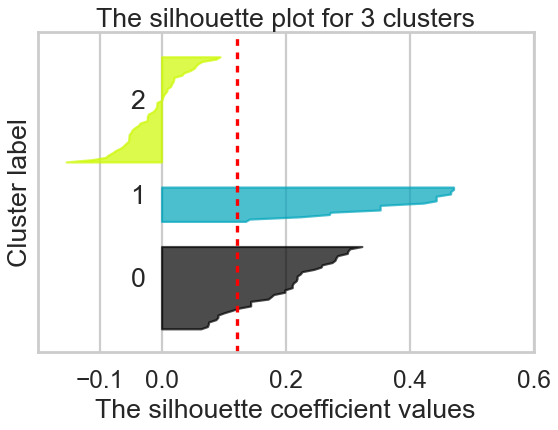

For n_clusters = 4 The average silhouette_score is : 0.1008569352922785


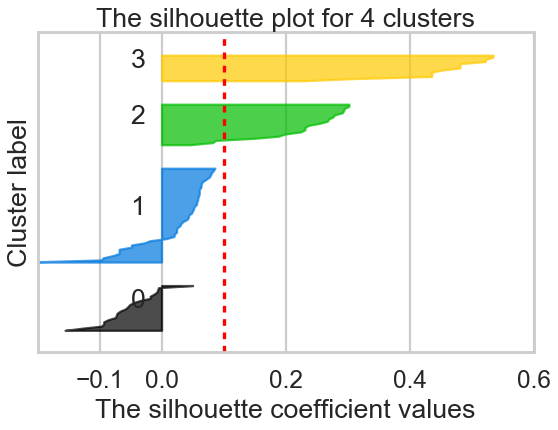

For n_clusters = 5 The average silhouette_score is : 0.10690914444877238


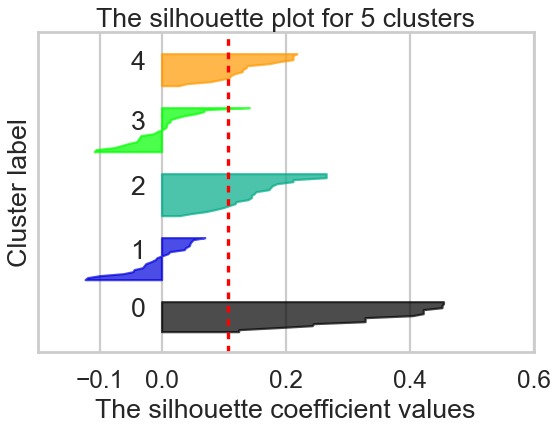

For n_clusters = 6 The average silhouette_score is : 0.13249594022480132


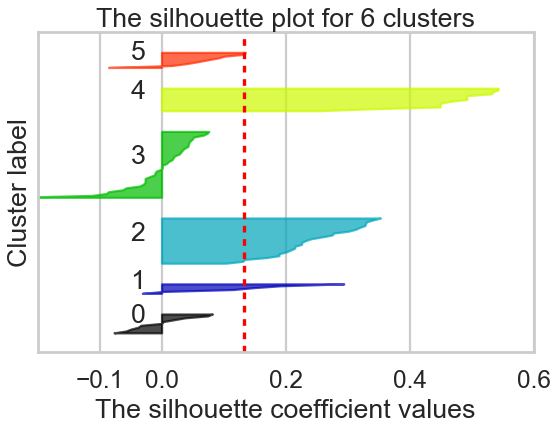

For n_clusters = 7 The average silhouette_score is : 0.118558183196058


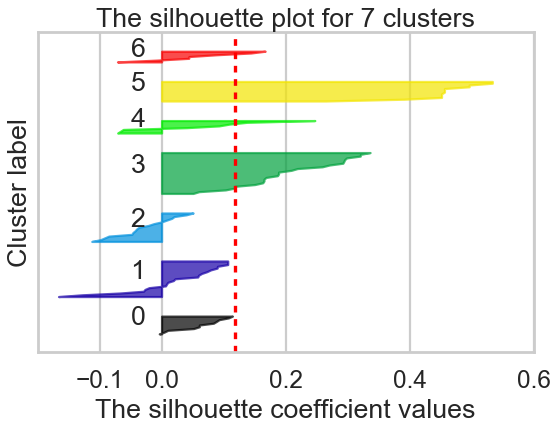

For n_clusters = 8 The average silhouette_score is : 0.13619400546844182


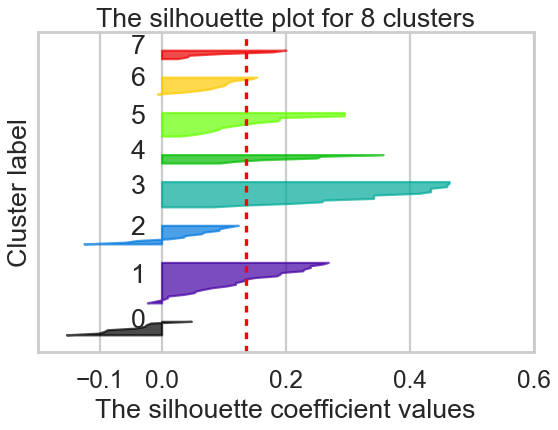

For n_clusters = 9 The average silhouette_score is : 0.11864233416850206


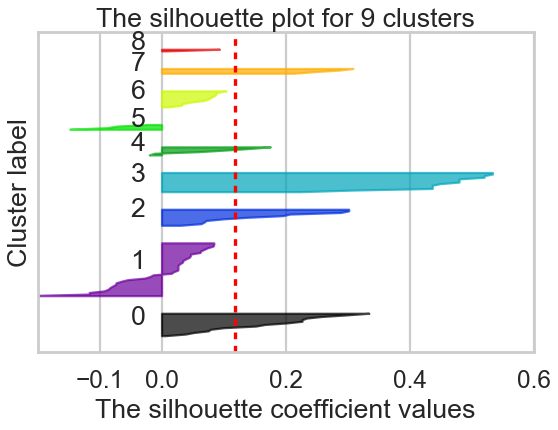

In [9]:
# Your turn.
print(__doc__)

for n_clusters in range(2,10):
    _ = plt.figure(figsize=(8,5))
    # The 1st subplot is the silhouette plot
    _ = plt.xlim([-0.2, .6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    _ = plt.ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=20,init='k-means++')
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        _ = plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        _ = plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

#    _ = plt.title("The silhouette plot for the various clusters", size=15)
    _ = plt.title("The silhouette plot for %i clusters" %n_clusters)
    _ = plt.xlabel("The silhouette coefficient values")
    _ = plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    _ = plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    _ = plt.yticks([])  # Clear the yaxis labels / ticks
    _ = plt.xticks([-0.1, 0, 0.2, 0.4, 0.6])

    plt.show()


Text(0, 0.5, 'Average')

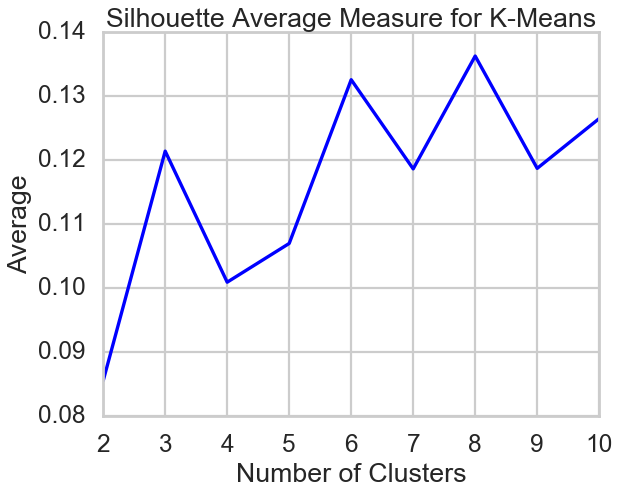

In [10]:
# Evaluate the silhouette average measure for KMeans with 2,3,...10 clusters
# Store silhuette coefficient, number of cluster and cluster results
ss = []
kk = []
cc = []
for k in range(2,11):
    kmod = KMeans(n_clusters = k, random_state=20,init='k-means++')
    cluster = kmod.fit_predict(x_cols)
    cc.append(cluster)
    silhouette_avg = silhouette_score(x_cols, cluster)

    ss.append(silhouette_avg)
    kk.append(k)
    
plt.plot(kk,ss)
plt.title("Silhouette Average Measure for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Average")

The figure suggests that the best number of clusters is eight. Clusters of size three and six seem to be two other potential picks in the silhouette averages.  

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [11]:
#your turn
# Get Principal Components from the Covariates Matrix (columns with indicators for offers purchases)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_f = pca.fit_transform(x_cols)[:,:2]


In [12]:
# Combine customer name, top 2 principal components from covariates matrix, and cluster id
cust_pcc1 = cust_offers.iloc[:,0]
cust_pcc = pd.concat([cust_pcc1, pd.DataFrame(pca_f), pd.DataFrame(cc).T], axis=1,join='inner')
cust_pcc.columns = ['customer_name','PCA1','PCA2','NK_2','NK_3','NK_4','NK_5','NK_6','NK_7','NK_8','NK_9','NK_10']
print(cust_pcc.shape)
print(cust_pcc.head())

(100, 12)
  customer_name      PCA1      PCA2  NK_2  NK_3  NK_4  NK_5  NK_6  NK_7  NK_8  \
0         Adams  1.007580  0.108215     0     0     2     2     2     3     1   
1         Allen -0.287539  0.044715     1     2     1     1     5     1     1   
2      Anderson -0.392032  1.038391     1     1     3     0     4     5     3   
3        Bailey  0.699477 -0.022542     0     0     2     4     2     3     1   
4         Baker  0.088183 -0.471695     1     2     1     4     3     0     6   

   NK_9  NK_10  
0     0      2  
1     1      0  
2     3      3  
3     2      1  
4     2      4  


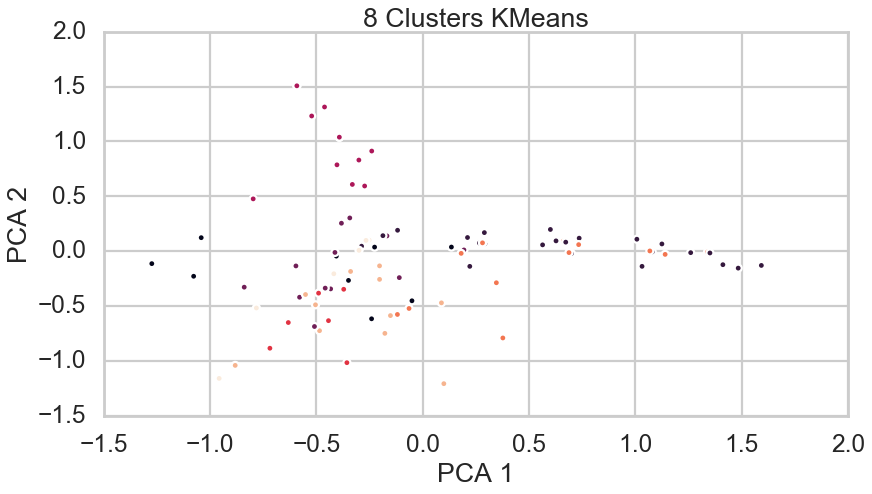

In [13]:
_ = plt.figure(figsize=(12,6))

_ = plt.scatter(cust_pcc.PCA1, cust_pcc.PCA2, c=cust_pcc.NK_8,s=40)
_ = plt.title("8 Clusters KMeans")
_ = plt.xlabel("PCA 1")
_ = plt.ylabel("PCA 2")
plt.show()

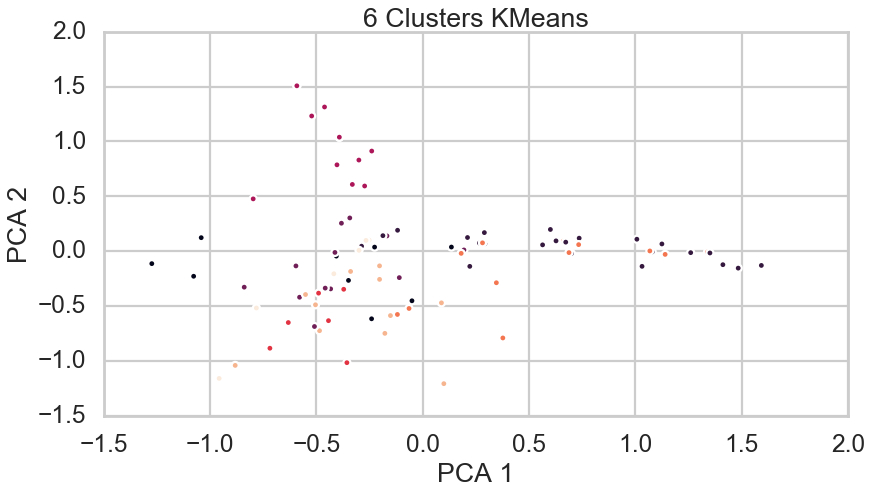

In [14]:
_ = plt.figure(figsize=(12,6))

_ = plt.scatter(cust_pcc.PCA1, cust_pcc.PCA2, c=cust_pcc.NK_8,s=40)
_ = plt.title("6 Clusters KMeans")
_ = plt.xlabel("PCA 1")
_ = plt.ylabel("PCA 2")
plt.show()

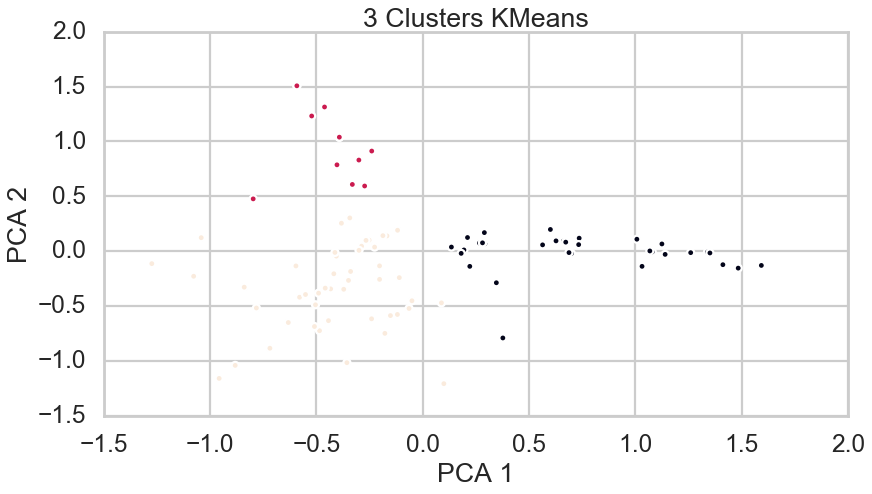

In [15]:
_ = plt.figure(figsize=(12,6))

_ = plt.scatter(cust_pcc.PCA1, cust_pcc.PCA2, c=cust_pcc.NK_3,s=40)
_ = plt.title("3 Clusters KMeans")
_ = plt.xlabel("PCA 1")
_ = plt.ylabel("PCA 2")


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

By just looking at the pictures, 3 clusters seems to do better. There is no overlap and the points clearly define separate areas. This is supported by the elbo method, and partially supported by the silhouette graph.

### How well clusters identify the different characteristics of the sale?

None of the two cluster sets identified as potetially optimal do a good job isolating any single one of the wine sale characteristics. However, the clusters reflect some patterns. For example, Pinot Noir wines are mainly grouped in one of the clusters. This means that individuals purchasing this variety are clustered together. Pinot Grigio and Espumante are both also fairly grouped in a single group. This means that people that like Pinot Noir are closer to eachother than to people that like other wine varieties. The same can be said to individuals that like Pinot Grigio wines and Espumante. 

If we look at the 3-cluster groups we find people that likes Cavernet Sauvignon, Chardonay and Campaigne are closer to eachother. These are the more traditional variaties. 

Another interesting aspect to explore is the identification of discount levels by the clusters however, each cluster shows a large variability in the level of discounts for wines purchased. In the 3-cluster boxplots for discount levels, we can identify a large group that tends to buy highly discounted wines. The majority of individuals in this group purhase wines with discounts from about 50% to discounts as large as 80% or even more. There is a second group that purchases wines with a significant discount, around 50%, but who doen't in general purchase wines with much higher discounts than that. The third group, a more intersting one, seems to be willing to pay higher prices for wine, but they will still buy wines with high levels of discounts.

Index(['customer_name', 'offer_id', 'n', 'campaign', 'varietal', 'min_qty',
       'discount', 'origin', 'past_peak', 'PCA1', 'PCA2', 'NK_2', 'NK_3',
       'NK_4', 'NK_5', 'NK_6', 'NK_7', 'NK_8', 'NK_9', 'NK_10'],
      dtype='object')
Heatmap - Cluster vs varietal


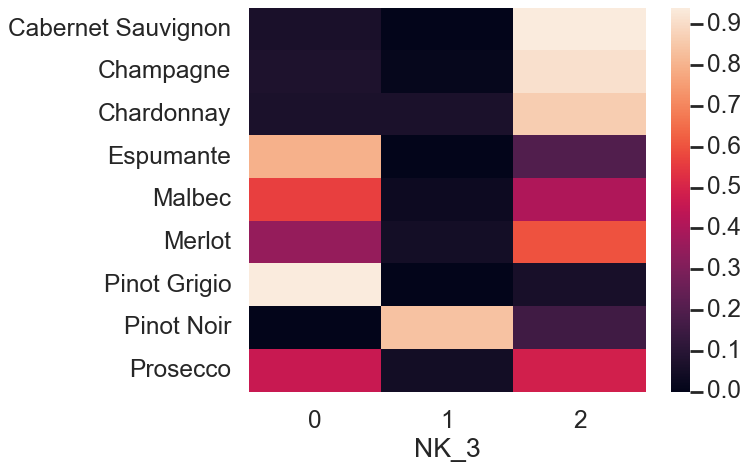

Heatmap - Cluster vs varietal


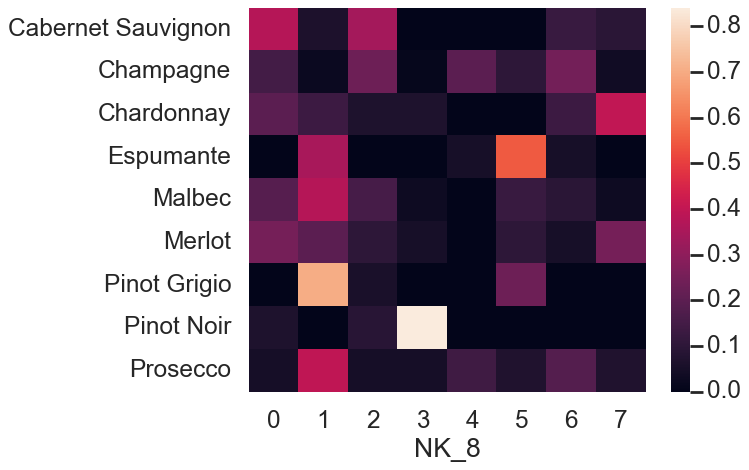

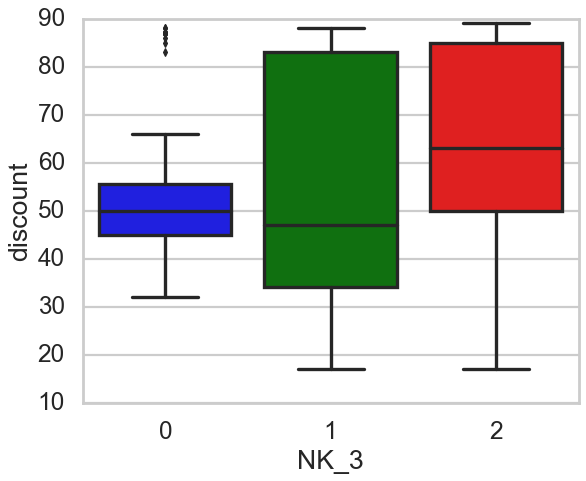

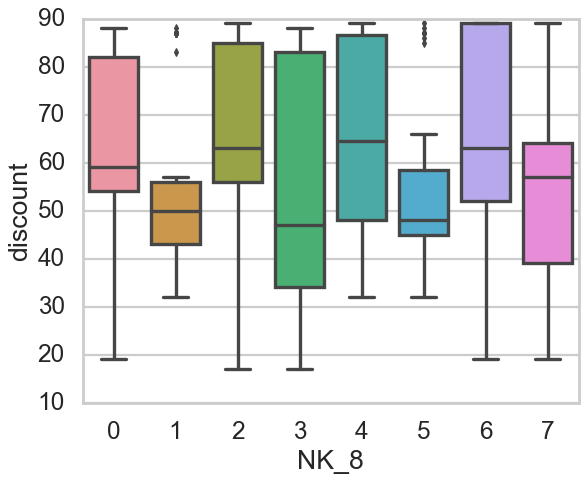

In [16]:
### COMBINE CLUSTER DATA WITH PURCHASES CHARACTERISTICS
sales_winedesc=df_transactions.merge(df_offers,sort=True)
sales_full=sales_winedesc.merge(cust_pcc)
print(sales_full.columns)

def winech(X,cl):
    gr = sales_full.groupby([X,cl])['n'].count()
    gr_us = gr.unstack(level=cl).fillna(0)
    gr_l = []
    for i in gr_us.index:
        gr_l.append(gr_us.loc[i]/gr_us.loc[i].sum())
    ax = sns.heatmap(pd.DataFrame(gr_l))
    print("Heatmap - Cluster vs %s" %X)
    plt.show()
    
winech('varietal','NK_3')
winech('varietal','NK_8')
#winech('campaign','NK_3')
#winech('origin','NK_3')
#winech('past_peak','NK_3')

sns.boxplot(x=sales_full['NK_3'],y=sales_full['discount'])
plt.show()
sns.boxplot(x=sales_full['NK_8'],y=sales_full['discount'])
plt.show()


<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

[3.59681971 2.95221271 2.41774033 2.03374375 1.84733658 1.50565996
 1.46934931 1.38692224 1.15772528 1.12021518 1.06137657 1.02812667
 0.99429047 0.96339254 0.85799171 0.79894176 0.7481957  0.70499212
 0.66601522 0.62701761 0.58082608 0.57434818 0.51350678 0.46633521
 0.4560069  0.4092627  0.31314557 0.26891216 0.25414257 0.22840745
 0.17161782 0.14865549]


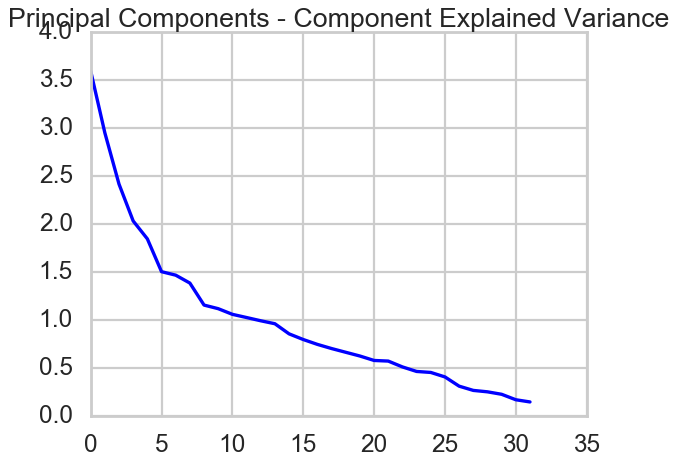

In [17]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler, normalize 

scaler = StandardScaler() 
x_scaled = scaler.fit_transform(x_cols) 

pca = sklearn.decomposition.PCA()
pca.fit(x_scaled)

_ = plt.plot(pca.explained_variance_)
_ = plt.title("Principal Components - Component Explained Variance")

print(pca.explained_variance_)

Using the principal component analysis, and looking at the portion of the variance explained as we add more components, the optimum number of vectors to select is either 5 or 8. After adding the 5th principal components, the next two components add marginal explanation to the variance. The eight components has again significant increase in variance explanation. After the eight component, the increase in information is marginal, with the increased variace curve going slowly down.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### 1. Affinity propagation

Silhouette Score: 0.06912973302366232
Estimated number of clusters: 6


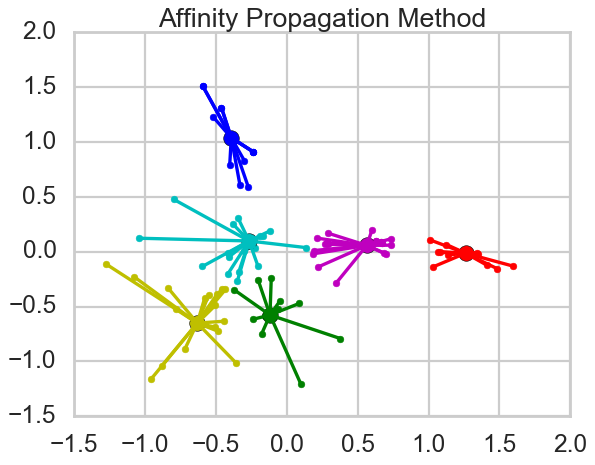

In [18]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

pca_2 = cust_pcc[['PCA1','PCA2']].to_numpy()

af = AffinityPropagation(preference=-2).fit(pca_2)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

labels = af.labels_

### Compute the silhouette score based on distances using all features to be comparable with K-means.
print("Silhouette Score:",silhouette_score(x_cols, labels))

print('Estimated number of clusters: %d' % n_clusters_)

# #############################################################################
# Plot result
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = pca_2[cluster_centers_indices[k]]
    plt.plot(pca_2[class_members, 0], pca_2[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in pca_2[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Method')
plt.show()


### 2 - Spectral Clustering

# of clusters: 3 - Silhouette Score: 0.106


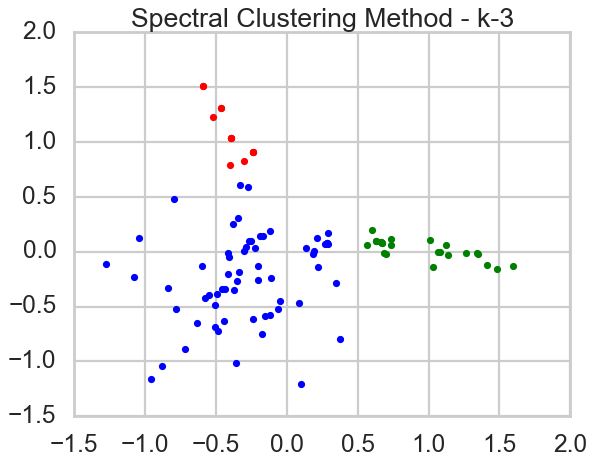

In [19]:
from sklearn.feature_extraction import image
from sklearn.cluster import SpectralClustering 
plt.close('all')
plt.figure(1)
plt.clf()

n_clusters=3

# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = n_clusters, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(pca_2) 
silscr = silhouette_score(x_cols, labels_rbf)
print('# of clusters: 3 - Silhouette Score: %4.3f' %silscr)

# Building the label to colour mapping 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(n_clusters), colors):
    class_members = labels_rbf == k
    plt.scatter(pca_2[class_members, 0], pca_2[class_members, 1], color=col)

plt.title('Spectral Clustering Method - k-3')
plt.show()


### 3 - Aglomerati Cluster

In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr

n_clusters=3
aglom_clst = AgglomerativeClustering(n_clusters=n_clusters).fit(pca_2)
aglom_labels = aglom_clst.labels_

Aglomerati Cluster - # of clusters: 3 - Silhouette Score: 0.120


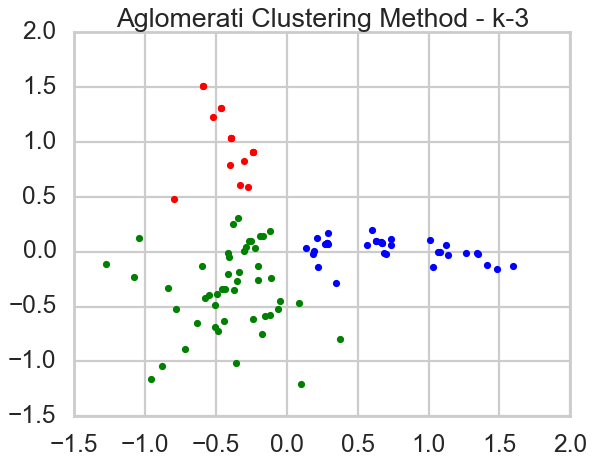

In [21]:
aglmscr = silhouette_score(x_cols, aglom_labels)
print('Aglomerati Cluster - # of clusters: 3 - Silhouette Score: %4.3f' %aglmscr)

# Building the label to colour mapping 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(n_clusters), colors):
    class_members = aglom_labels == k
    plt.scatter(pca_2[class_members, 0], pca_2[class_members, 1], color=col)

plt.title('Aglomerati Clustering Method - k-3')
plt.show()


### 4. DBSCAN

In [22]:
from sklearn.cluster import DBSCAN


In [23]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(pca_2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"  % silhouette_score(x_cols, labels))

Estimated number of clusters: 3
Estimated number of noise points: 13
Silhouette Coefficient: 0.048


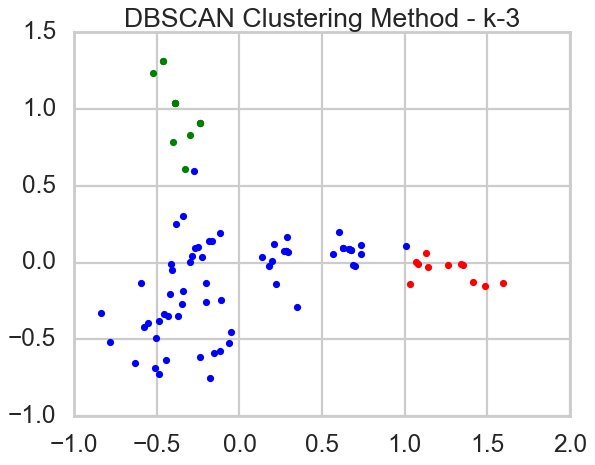

In [24]:
# Building the label to colour mapping 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    plt.scatter(pca_2[class_members, 0], pca_2[class_members, 1], color=col)

plt.title('DBSCAN Clustering Method - k-3')
plt.show()


In order to compare the clustering methods we use the first two principal components identified from the offers matrix. We fit the cluster models using only these two variables and when a pre-defined set of clusters is required we set it to three. We then use the average silhuette measure based on the distances using the full matrix to evaluate the fit.

The K-means and the Aglomeratti methods are the ones rendering better results. This is clear in the higher silhuette scores, and also in the graphical representation.